# Dataset: [Breakfast](https://serre-lab.clps.brown.edu/resource/breakfast-actions-dataset/)


```
# tensorflow, transformer
```



In [1]:
import tensorflow as tf

import os
import time
import numpy as np

import matplotlib.pyplot as plt

# From annotation work
- Read Breakfast Dataset


In [2]:
# read the dataset and some exploration

g = os.walk(r"/content/drive/MyDrive/FurtherStudy/Project2020/groundTruthlabel-breakfastdatset/")
# g is a generator with (path,dir_list,file_list)
# https://blog.csdn.net/mighty13/article/details/77995857

file_list = list(g)  # path,dir_list,file_list in g
path, _, file_list = file_list[0]

fps = 15
resolution = (320, 240)  # 320 * 240
# 52 different individuals, 18 different kitchens, 10 cooking activities
person = {}  
cams = {}  
activity = {} 
data_files = []  # txt data file names

for file_name in file_list:
  if file_name.endswith(".txt"):
    data_files.append(file_name)
    pts = file_name[:file_name.rfind('.')].split('_')
    person[pts[0]] = person[pts[0]] + 1 if pts[0] in person else 1
    cams[pts[1]] = cams[pts[1]] + 1 if pts[1] in cams else 1
    activity[pts[3]] = activity[pts[3]] + 1 if pts[3] in activity else 1

print("Individuals:", person)
print("Camera:", cams)
print("Activities:", activity)

Individuals: {'P51': 46, 'P30': 23, 'P43': 40, 'P14': 29, 'P07': 18, 'P36': 37, 'P13': 23, 'P29': 25, 'P32': 25, 'P23': 44, 'P37': 40, 'P49': 46, 'P27': 35, 'P35': 32, 'P41': 50, 'P20': 39, 'P21': 40, 'P04': 30, 'P17': 34, 'P24': 42, 'P52': 45, 'P16': 37, 'P18': 33, 'P53': 43, 'P42': 48, 'P46': 44, 'P31': 23, 'P47': 41, 'P26': 31, 'P38': 40, 'P22': 41, 'P19': 32, 'P12': 20, 'P39': 43, 'P11': 19, 'P54': 44, 'P15': 29, 'P25': 33, 'P28': 10, 'P05': 11, 'P33': 24, 'P44': 45, 'P48': 42, 'P50': 48, 'P34': 25, 'P40': 46, 'P03': 26, 'P45': 44, 'P06': 11, 'P08': 12, 'P09': 15, 'P10': 9}
Camera: {'webcam01': 365, 'cam02': 272, 'webcam02': 338, 'stereo01': 304, 'cam01': 433}
Activities: {'sandwich': 169, 'friedegg': 173, 'cereals': 184, 'scrambledegg': 166, 'pancake': 157, 'salat': 163, 'tea': 184, 'milk': 187, 'juice': 162, 'coffee': 167}


- Convert into Video Stream

In [3]:
# Video Stream Class
class VideoStream:
  def __init__(self, stream=None):
    self.stream = stream
    self.total_frame = 0
    if stream is not None:
      for _, count in stream:
        self.total_frame += count


class VideoStream1(VideoStream):
  """Video stream as a list of action and frame count
  Designed for files like those txt files of the breakfast dataset
  """
  def __init__(self, path=None, file_name=None, fps=15, remove=["SIL"],stream=None):
    self.fps = fps  # frame rate of the original videos
    self.remove = remove
    self.file_name = file_name  
    super(VideoStream1, self).__init__(stream)
    if path is not None and file_name is not None:
      stream = []
      f = open(path+file_name, 'r')
      temp = ""
      count = 0
      for line in f.readlines():
        line = line.strip()
        if line == temp:
          count += 1
        elif line not in remove:
          if count > 0:
            stream.append((temp, count))
            self.total_frame += count
          temp = line
          count = 1
      if temp not in remove and count > 0:
        stream.append((temp, count))
        self.total_frame += count
      self.stream = stream  # a list of (action, frame count)
      f.close()

  @property
  def jsonName(self):
    """return json information from file name, including activity/purpose"""
    if self.file_name is None:
      return None
    file_name = self.file_name
    pts = file_name[:file_name.rfind('.')].split('_')
    return {"file_name":file_name, "person":pts[0], "camera":pts[1], "activity":pts[3]}

  def obs_by_frame_index(self, end, start=0):
    """return the observation stream between the two given index of frame
    [start, end)
    """
    obs = []
    remain_start = start
    remain_end = end
    for action, count in self.stream:
      if remain_end == 0:
        return obs
      if count <= remain_start:
        remain_start -= count
        remain_end -= count
      else:
        if remain_start > 0:
          count -= remain_start
          remain_end -= remain_start
          remain_start = 0
        if count > remain_end:
          obs.append((action, remain_end))
          return obs
        else:
          remain_end -= count
          obs.append((action, count))
    return obs

  def action_by_frame_index(self, index):
    """return the action at the given index of frame; return None if the index
    is too large to stay in range
    """
    remain = index
    action_index = 0
    for action, count in self.stream:
      if count > remain:
        return action, action_index
      else:
        remain -= count
        action_index += 1
    return None, len(self.stream)
    
  def label_obs(self, sps, ts):
    """ take the first sps part of the data as observations and label the action
     at t seconds after an observation ends

    split: partial percentage of a video as observation
    ts: sec after the observation that we interested

    return: json of observations and their labels
    """
    n = self.total_frame
    res = {}
    for p in sps:
      n_obs = int(np.round(n*p))
      obs = self.obs_by_frame_index(n_obs)
      action_label = []
      for t in ts:
        frame = n_obs + int(self.fps*t)
        action_label.append(self.action_by_frame_index(frame-1))
      res[p] = {"observation":obs, "tsec":ts, "action_labels":action_label}
    return res


class VideoStream2(VideoStream1):
  def label_obs(self, ts, step, window_size, unit_is_second=True):
    """use sliding window instead of ratio
    unit: second if unit_is_second==True else frame
    """
    fps = self.fps
    if unit_is_second:
      step *= fps
      window_size *= fps
    res = []
    n_obs = window_size
    while n_obs <= self.total_frame:
      start, end = n_obs-window_size, n_obs
      obs = self.obs_by_frame_index(start=start, end=end)
      last_action = self.action_by_frame_index(n_obs-1)
      action_label = []
      for t in ts:
        frame = n_obs + int(fps*t)
        action_label.append(self.action_by_frame_index(frame-1))
      res.append({"observation":obs, "obs_frame":(start, end), "last_action":last_action, "tsec":ts, "action_labels":action_label})
      n_obs += step
    return res

- Produce observations and explanations

In [ ]:
def annotation2(video, step=10, window_size=30, ts=[1, 3, 5, 7, 10, 20, 30, 40, 50, 60]):
  """return the list for annotation of the video. One element will be:
  [file_name,goal,obs_frame_range,obs_time_range,second_last_action,last_action,t,action,explanation,explanation_type] 
  """
  res = []
  file_name = video.jsonName["file_name"]
  goal = video.jsonName["activity"]
  labels_obs = video.label_obs(ts=ts,step=step,window_size=window_size)
  for obs_info in labels_obs:
    obs = obs_info["observation"]
    start, end = obs_info["obs_frame"]
    obs_frame_range = str(start) + ':' + str(end)
    obs_time_range = str(np.round(start/video.fps,decimals=2)) + ':' + str(np.round(end/video.fps,decimals=2))
    second_last_action = None
    last_action, last_action_index = obs_info["last_action"]
    if len(obs) > 1:
      second_last_action = obs[-2][0]
    for i in range(len(ts)):
      t = ts[i]
      action, action_index = obs_info["action_labels"][i]
      index_diff = action_index - last_action_index
      explanation = ""  # may need to be done manually
      explanation_type = "None"
      if action is None:
        explanation = "None"
      elif last_action is None:
        explanation = "Because the person just starts with this action " + action
      elif index_diff == 0:
        explanation = "Because the last action " + action + " is not finished"
        explanation_type = 0
      elif index_diff < 4:
        constituting = {1: "", 2: "second ", 3: "third "}
        explanation = "Because the person will do the next " + constituting[index_diff] + "action " + action + " after the current action " + last_action
        explanation_type = index_diff
      else:
        explanation = "Because the person will do this action " + action + " after the current action " + last_action
        explanation_type = 3
#      if action is not None and (goal in action or index_diff > 3):
#        explanation += " and the goal is to make " + goal
      res.append([file_name,goal,obs_frame_range,obs_time_range,second_last_action,last_action,t,action,explanation,explanation_type])
  return res

- Write into a CSV file

In [ ]:
f = open("annotation_breakfast2.csv", 'w')
f.write("file_name,goal,obs_frame_range,obs_time_range,second_last_action,last_action,t,action,explanation,explanation_type\n")
counter = 0
for fileN in data_files:
  video = VideoStream2(path,fileN)
  lines = annotation2(video,step=10)
  for line in lines:
    line = ','.join([str(item) for item in line]) + "\n"
    f.write(line)
  counter += 1
  if counter % 100 == 0:
    print("finished file:",counter)
f.close()

# Transformer part 1: output without explanation
reference: [Transformer model for language understanding](https://www.tensorflow.org/tutorials/text/transformer)

## Set up input pipeline

1. Reduce the observations into 1 fps and produce the features. 



In [7]:
# action exploration for the Breakfast dataset
action_set = set()
for fileN in data_files:
  video = VideoStream2(path,fileN)
  for pairs in video.stream:
    if pairs[0] not in action_set:
      action_set.add(pairs[0])

print(action_set)
len(action_set)

{'fry_pancake', 'put_fruit2bowl', 'pour_sugar', 'smear_butter', 'peel_fruit', 'pour_juice', 'cut_orange', 'take_topping', 'stir_tea', 'take_glass', 'pour_coffee', 'put_toppingOnTop', 'spoon_powder', 'pour_oil', 'stir_coffee', 'stir_cereals', 'fry_egg', 'stir_milk', 'take_butter', 'take_knife', 'put_pancake2plate', 'pour_water', 'pour_milk', 'stir_fruit', 'take_plate', 'stirfry_egg', 'cut_fruit', 'pour_flour', 'spoon_flour', 'add_teabag', 'stir_dough', 'cut_bun', 'take_squeezer', 'stir_egg', 'add_saltnpepper', 'put_egg2plate', 'pour_egg2pan', 'take_eggs', 'squeeze_orange', 'pour_dough2pan', 'take_bowl', 'spoon_sugar', 'pour_cereals', 'butter_pan', 'take_cup', 'crack_egg', 'put_bunTogether'}


47

In [8]:
# encode and decode method for one-hot code of actions
action_lst = []
action_dict = {}
index = 0
for action in action_set:
  if action not in action_dict:
    action_lst.append(action)
    action_dict[action] = index
    index += 1
"""
def action_encode(action):
  onehot = np.zeros(len(action_set),dtype=int)
  if action in action_dict:
    onehot[action_dict[action]] = 1
  return onehot

def action_decode(onehot):
  for index in range(len(onehot)):
    if onehot[index] == 1:
      return action_lst[index]
  return None
"""
def action_encode(action):
  if action is not None and action in action_dict:
    return action_dict[action] + 1
  return 0

def action_decode(token):
  if token > 0 and token <= len(action_lst):
    return action_lst[token-1]
  return None

In [5]:
q = 30
fps = 15
ts=[1, 3, 5, 7, 10, 20, 30, 40, 50, 60]
step = 10

In [6]:
def build_features(obs):
  features = []
  remain = 0

  for action, frame_count in obs:
    if remain > 0:
      frame_count += remain - fps
      if remain < fps/2:
        features += [action_encode(action)]
    i = int(frame_count/fps)
    features += [action_encode(action)] * i
    remain = frame_count - i * fps
#    if remain<0 or remain>=fps:
#      print(obs, action, frame_count, i, remain)
#      raise Exception()
    if remain >= fps/2:
      features += [action_encode(action)]

  return np.array(features)

2. Build the training dataset and cross validation: fold split

- s1: P03 – P15
- s2: P16 – P28
- s3: P29 – P41
- s4: P42 – P54

In [9]:
train_obs_features = [[] for _ in range(4)]
train_tar_action = [[] for _ in range(4)]
train_exp_type = [[] for _ in range(4)]
train_exp = [[] for _ in range(4)]

for fileN in data_files:
  video = VideoStream2(path,fileN)
  person = int(video.jsonName["person"][1:])
  labels_obs = video.label_obs(ts=ts,step=step,window_size=q)
  for obs_info in labels_obs:
    obs = obs_info["observation"]
    last_action, last_action_index = obs_info["last_action"]

    target_action = []
    target_explanation = []
    target_explanation_type = []

    for i in range(len(ts)):
      t = ts[i]
      action, action_index = obs_info["action_labels"][i]
      index_diff = action_index - last_action_index
      explanation = ""
      explanation_type = np.zeros(4)
      if action is None:
        explanation = "None"
      elif index_diff == 0:
        explanation = "Because the last action " + action + " is not finished"
        explanation_type[0] = 1
      elif index_diff < 4:
        constituting = {1: "", 2: "second ", 3: "third "}
        explanation = "Because the person will do the next " + constituting[index_diff] + "action " + action + " after the current action " + last_action
        explanation_type[index_diff] = 1
      else:
        explanation = "Because the person will do this action " + action + " after the current action " + last_action
        explanation_type[-1] = 1
      
      target_action.append(action_encode(action))
      target_explanation.append(np.array([explanation]))
      target_explanation_type.append(explanation_type)
    
    if person < 16:
      split = 0
    elif person < 29:
      split = 1
    elif person < 42:
      split = 2
    else:
      split = 3
    train_obs_features[split].append(tf.constant(build_features(obs)))
    train_tar_action[split].append(tf.constant(target_action))
    train_exp_type[split].append(tf.constant(target_explanation_type))
    train_exp[split].append(tf.constant(target_explanation))

[len(train_obs_features[s]) for s in range(4)]

[2526, 4861, 4443, 6208]

save dataset

In [10]:
train_dataset = [[] for _ in range(4)]

for s in range(4):
  train_dataset[s] = tf.data.Dataset.from_tensor_slices((train_obs_features[s],train_tar_action[s],train_exp_type[s],train_exp[s]))
  tf.data.experimental.save(train_dataset[s], "/content/drive/MyDrive/FurtherStudy/Project2020/breakfast_data_s"+str(s+1))

In [71]:
next(iter(train_dataset[0]))[:2]

(<tf.Tensor: shape=(64, 30), dtype=int64, numpy=
 array([[43, 43, 43, ..., 43, 43, 43],
        [26, 26, 26, ..., 26, 26, 26],
        [43, 43, 43, ..., 41, 10, 10],
        ...,
        [ 5,  5,  5, ...,  5,  5,  5],
        [ 5,  5,  5, ...,  5,  5,  5],
        [ 5,  5,  5, ...,  5,  5,  5]])>,
 <tf.Tensor: shape=(64, 10), dtype=int32, numpy=
 array([[43, 43, 43, 43, 43, 28, 10, 10, 10, 10],
        [26, 26, 26, 26, 39, 39,  5,  5,  5,  5],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [23, 23, 23, 23, 23, 31,  0,  0,  0,  0],
        [ 8,  8,  8, 29, 29,  0,  0,  0,  0,  0],
        [13, 13, 13, 13, 13, 13, 13, 13, 13, 13],
        [ 5,  5,  5,  5,  5,  5,  5, 33,  0,  0],
        [ 5,  5,  5,  5,  5,  5,  5,  5,  5,  5],
        [32, 32, 32, 32, 32,  0,  0,  0,  0,  0],
        [ 8,  8,  8,  8,  8,  8,  8, 29, 29,  0],
        [42,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 8,  8,  8,  8,  8, 34, 29, 29,  0,  0],
        [32, 32, 32, 32, 32, 32, 24, 24, 32, 32],
  

load dataset

In [19]:
# load from saved files
def load_dataset(path):
  return tf.data.experimental.load(
    path,
    (tf.TensorSpec(shape=(30, ), dtype=tf.int64, name=None),
     tf.TensorSpec(shape=(10, ), dtype=tf.int32, name=None),
     tf.TensorSpec(shape=(10, 4), dtype=tf.float64, name=None),
     tf.TensorSpec(shape=(10, 1), dtype=tf.string, name=None)))

In [ ]:
train_dataset = [[] for _ in range(4)]
dataset_path = "/content/drive/MyDrive/FurtherStudy/Project2020/breakfast_data_s"
for s in range(4):
  train_dataset[s] = load_dataset(dataset_path+str(s+1))

shuffle and other things

In [11]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [ ]:
"""# split train-val: size = (17k,1k)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
val_dataset = train_dataset.take(1000) 
train_dataset = train_dataset.skip(1000)

In [12]:
# speedup, shuffle and batch
"""
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE,reshuffle_each_iteration=True)
train_dataset = train_dataset.padded_batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.padded_batch(BATCH_SIZE)
"""
for s in range(4):
  train_dataset[s] = train_dataset[s].cache()
  train_dataset[s] = train_dataset[s].shuffle(BUFFER_SIZE,reshuffle_each_iteration=True)
  train_dataset[s] = train_dataset[s].padded_batch(BATCH_SIZE)
  train_dataset[s] = train_dataset[s].prefetch(tf.data.AUTOTUNE)

In [ ]:
obs_feature, tar_action, expl_type, expl = next(iter(train_dataset[0]))

## Transformer Model

https://keras.io/examples/nlp/text_classification_with_transformer/

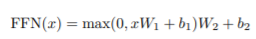

In [13]:
# Position-wise Feed-Forward Networks
def pw_ffn(d_model, dff):
  """
  output dim: d_model
  inner layer dim: dff
  """
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [ ]:
# attention
# tf.keras.layers.MultiHeadAttention(num_heads=?, key_dim=d_model)
# norm layer
# tf.keras.layers.LayerNormalization(epsilon=1e-6)

In [38]:
class TransformerLayer(tf.keras.layers.Layer):
  """
  mha -> normal -> ffn -> normal
  """
  def __init__(self, d_model, num_heads, dff, dropout):
    super(TransformerLayer, self).__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout)
    self.ffn = pw_ffn(d_model, dff)
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)   
    
  def call(self, x):
    attn = self.mha(x, x)  # (batch_size, timesteps, d_model)
    out1 = self.layernorm1(attn + x)
    ffn_output = self.ffn(out1)  
    out2 = self.layernorm2(ffn_output + out1)  # (batch_size, timesteps, d_model)
    return out2

In [39]:
class Transformer(tf.keras.Model):
  """
  d_model = dim_action_embed + dim_time_embed

  Arch:
  Concat(action_embedding, time_embedding)  (batch_size, timesteps, d_model)
  -> N * Transformer layer                  (same shape)
  -> Average on timestep                    (batch_size, d_model)
  -> Softmax FC                             (batch_size, action_size)

  Output: batch_size probability vectors
  """
  def __init__(self, num_layers, action_embed_dim, time_embed_dim, num_heads, dff, time_size, action_size, dropout):
    super(Transformer, self).__init__()
    self.d_model = action_embed_dim + time_embed_dim
    self.num_layers = num_layers
    
    self.action_embedding = tf.keras.layers.Embedding(action_size, action_embed_dim)
    self.time_embedding = tf.keras.layers.Embedding(time_size, time_embed_dim)
    self.transformer_layers = [TransformerLayer(d_model, num_heads, dff, dropout)  for _ in range(num_layers)]
    self.average_on_timestep = tf.keras.layers.GlobalAveragePooling1D()
    self.final_layer = tf.keras.layers.Dense(action_size, activation="softmax")

  def call(self, x):
    x, t = x[:, :-1], x[:, -1]
    # (x.shape, t.shape) = ((batch_size, timesteps), (batch_size, ))
    ut = self.time_embedding(t)  
    ut = tf.repeat(ut[:, np.newaxis, :], x.shape[1], axis=1)

    x = self.action_embedding(x)  
    x = tf.concat([x, ut], axis=2)     # (batch_size, timesteps, d_model)
    
    for i in range(self.num_layers):
      x = self.transformer_layers[i](x)
    
    x = self.average_on_timestep(x)
    action_prob = self.final_layer(x)
    return action_prob

In [16]:
# hyperparameters
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
time_embed_dim = 4
action_embed_dim = d_model - time_embed_dim
time_size = 61
action_size = 48
dropout = 0

In [40]:
transformer = Transformer(num_layers, action_embed_dim, time_embed_dim, num_heads, dff, time_size, action_size, dropout)

In [41]:
# try it out
feature_vec, action_gts = next(iter(train_dataset[0]))[:2]
t = tf.constant([1] * BATCH_SIZE, dtype=tf.int64)
print(feature_vec.shape)
print(t.shape)
inputs = tf.concat([feature_vec, t[:, np.newaxis]], axis=1)
print(inputs.shape)
transformer(inputs)

(64, 30)
(64,)
(64, 31)


<tf.Tensor: shape=(64, 48), dtype=float32, numpy=
array([[0.0126037 , 0.05033874, 0.02474671, ..., 0.05431449, 0.01325358,
        0.05294066],
       [0.00471926, 0.00488957, 0.01696076, ..., 0.03369428, 0.01474323,
        0.01867529],
       [0.00800071, 0.03373576, 0.00163424, ..., 0.00884827, 0.01512288,
        0.0033734 ],
       ...,
       [0.00186551, 0.00411144, 0.02881517, ..., 0.01832406, 0.00557621,
        0.01114837],
       [0.00167478, 0.00840278, 0.00268359, ..., 0.01019125, 0.00353074,
        0.00483252],
       [0.00150605, 0.0076069 , 0.00227459, ..., 0.0091827 , 0.00305254,
        0.00406044]], dtype=float32)>

## Training & evaluation by 4-Fold Cross Validation

In [80]:
learning_rate = 1e-3
EPOCHS = 10
#optimizer = tf.optimizers.Adam(learning_rate, decay=learning_rate/EPOCHS)
optimizer = tf.optimizers.Adam(learning_rate)

In [66]:
def fitting_generator(dataset):
  """
  a generator yielding the inputs and labels; dataset: tf.data.Dataset
  """
  for x in iter(dataset):
    inputs, action_gts = x[0], x[1]
    batch_size = x[1].shape[0]
    t_lst, targets = [], []
    for bs in range(batch_size):
      imax = 1
      while imax < 10 and action_gts[bs, imax].numpy() > 0:
        imax += 1
      i = np.random.randint(imax)
      targets.append(action_gts[bs, i].numpy())
      t_lst.append(ts[i])
    inputs = tf.concat([inputs, tf.constant(t_lst, dtype=tf.int64)[:, np.newaxis]], axis=1) 
    targets = tf.constant(targets)
    yield inputs, targets

def fitting_validation_dataset(dataset):
  input_lst, target_lst = [], []
  for x in iter(dataset):
    inputs, action_gts = x[0], x[1]
    batch_size = inputs.shape[0]
    for bs in range(batch_size):
      imax = 1
      while imax < 10 and action_gts[bs, imax].numpy() > 0:
        imax += 1
      i = np.random.randint(imax)
      input = np.append(inputs[bs, :].numpy(), ts[i])  # [x, t]
      target = np.zeros(action_size, dtype=int)
      target[action_gts[bs, i].numpy()] = 1  # one-hot code of the action
      input_lst.append(input)
      target_lst.append(target)
  res_set = tf.data.Dataset.from_tensor_slices((input_lst, target_lst))
  return res_set.padded_batch(BATCH_SIZE)

In [67]:
new_train_ds = [fitting_validation_dataset(train_dataset[s]) for s in range(4)]
next(iter(new_train_ds[0]))
# np.sum(next(iter(new_train_ds[0]))[1]) == 64

(<tf.Tensor: shape=(64, 31), dtype=int64, numpy=
 array([[46, 46, 46, ..., 46, 46,  7],
        [13, 13, 13, ..., 23, 23,  7],
        [25, 25, 25, ..., 39, 39,  3],
        ...,
        [12, 12, 12, ..., 12, 12,  3],
        [ 5,  5,  5, ..., 27, 27, 50],
        [17, 17, 36, ..., 36, 36, 20]])>,
 <tf.Tensor: shape=(64, 48), dtype=int64, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])>)

In [81]:
history = [None for _ in range(4)]
for s in range(4):
  print("------------------------------------------------------")
  print("Take s"+str(s+1)+" dataset as the testing set and concatenate the other 3 for training.\n")
  test_set = new_train_ds[s]
  tr_is = list(set(range(4)) - {s})
  training_set = new_train_ds[tr_is[0]].concatenate(new_train_ds[tr_is[1]]).concatenate(new_train_ds[tr_is[2]])
  transformer = Transformer(num_layers, action_embed_dim, time_embed_dim, num_heads, dff, time_size, action_size, dropout)
  optimizer = tf.optimizers.Adam(learning_rate)
  transformer.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
  history[s] = transformer.fit(x=training_set, validation_data=test_set, epochs=EPOCHS)

------------------------------------------------------
Take s1 dataset as the testing set and concatenate the other 3 for training.

Epoch 1/10
243/243 [==============================] - 275s 1s/step - loss: 1.2171 - accuracy: 0.6348 - val_loss: 0.9763 - val_accuracy: 0.7074
Epoch 2/10
243/243 [==============================] - 272s 1s/step - loss: 0.8509 - accuracy: 0.7248 - val_loss: 0.9355 - val_accuracy: 0.7098
Epoch 3/10
243/243 [==============================] - 272s 1s/step - loss: 0.7939 - accuracy: 0.7325 - val_loss: 0.9363 - val_accuracy: 0.7181
Epoch 4/10
243/243 [==============================] - 271s 1s/step - loss: 0.7735 - accuracy: 0.7340 - val_loss: 0.9788 - val_accuracy: 0.7118
Epoch 5/10
243/243 [==============================] - 270s 1s/step - loss: 0.7570 - accuracy: 0.7380 - val_loss: 0.9626 - val_accuracy: 0.7201
Epoch 6/10
243/243 [==============================] - 271s 1s/step - loss: 0.7519 - accuracy: 0.7449 - val_loss: 0.9282 - val_accuracy: 0.7225
Epoch 7/1

In [77]:
def predict(transformer, feature_vec, t):
  """ prediction of transformer
  transformer: Transformer; a transformer model.
  feature_vec: int numpy.array; a feature vector with size (timesteps, ).
  t: int; a scalar in range(1, 61).
  return: action string, probability vector, action code in range(48).
  """
  x = tf.constant(np.append(feature_vec, t))[np.newaxis, :]
  prob = transformer.predict(x)[0]
  code = np.argmax(prob)
  action = action_decode(code)
  return action, prob, code

In [74]:
# next(fitting_generator(train_dataset[0]))[:2]
# new_ds = fitting_validation_dataset(train_dataset[0])
x1, y1 = next(iter(new_train_ds[0]))
transformer.predict(x1[0:1, :])

array([[2.0744157e-04, 1.5675380e-03, 7.4660376e-05, 1.3063441e-04,
        4.9197860e-04, 2.0064093e-04, 2.0653177e-04, 1.1066241e-04,
        1.8729082e-04, 7.5888273e-04, 8.8978151e-04, 1.6779260e-04,
        1.0581568e-03, 1.0318370e-03, 1.6070422e-03, 5.2686245e-04,
        2.1011113e-04, 1.6056523e-02, 1.2942561e-04, 1.6121882e-04,
        7.6181954e-04, 2.2817160e-04, 5.4243568e-04, 9.9311303e-03,
        8.1982907e-05, 7.4083931e-03, 7.9221539e-03, 8.4808416e-05,
        2.9455023e-04, 1.7101312e-01, 5.4530782e-04, 2.6771026e-02,
        7.9283770e-04, 2.3331727e-04, 1.5213987e-01, 8.6652793e-02,
        7.9626724e-04, 3.7751701e-03, 9.2496208e-05, 1.1192705e-03,
        1.6696424e-03, 3.2191243e-04, 1.0995590e-03, 4.4380233e-04,
        5.6145426e-02, 1.5494972e-04, 4.4264314e-01, 5.5960804e-04]],
      dtype=float32)

In [76]:
x1[0:1, :]

<tf.Tensor: shape=(1, 31), dtype=int64, numpy=
array([[46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46,
        46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46,  7]])>

In [79]:
predict(transformer, x1[0, :-1].numpy(), x1[0, -1])

('crack_egg',
 array([2.0744157e-04, 1.5675380e-03, 7.4660376e-05, 1.3063441e-04,
        4.9197860e-04, 2.0064093e-04, 2.0653177e-04, 1.1066241e-04,
        1.8729082e-04, 7.5888273e-04, 8.8978151e-04, 1.6779260e-04,
        1.0581568e-03, 1.0318370e-03, 1.6070422e-03, 5.2686245e-04,
        2.1011113e-04, 1.6056523e-02, 1.2942561e-04, 1.6121882e-04,
        7.6181954e-04, 2.2817160e-04, 5.4243568e-04, 9.9311303e-03,
        8.1982907e-05, 7.4083931e-03, 7.9221539e-03, 8.4808416e-05,
        2.9455023e-04, 1.7101312e-01, 5.4530782e-04, 2.6771026e-02,
        7.9283770e-04, 2.3331727e-04, 1.5213987e-01, 8.6652793e-02,
        7.9626724e-04, 3.7751701e-03, 9.2496208e-05, 1.1192705e-03,
        1.6696424e-03, 3.2191243e-04, 1.0995590e-03, 4.4380233e-04,
        5.6145426e-02, 1.5494972e-04, 4.4264314e-01, 5.5960804e-04],
       dtype=float32),
 46)

# Previous attempts

In [35]:
class EncoderLayer(tf.keras.layers.Layer):
  """
  mha -> normal -> ffn -> normal
  call: output: the last dim is d_model
  """
  def __init__(self, d_model, num_heads, dff, dropout):
    super(EncoderLayer, self).__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout)
    self.ffn = pw_ffn(d_model, dff)
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
  def call(self, x):
    attn_output = self.mha(x, x)  # (batch_size, input_seq_len, d_model)
    out1 = self.layernorm1(x + attn_output)  
    ffn_output = self.ffn(out1)  
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    return out2

In [36]:
class DecoderLayer(tf.keras.layers.Layer):
  """
  mha -> normal -> mha(encoder output) -> normal -> ffn -> normal
  call: output: the last dim is d_model
  """
  def __init__(self, d_model, input_embed_dim, num_heads, dff, dropout):
    super(DecoderLayer, self).__init__()
    self.mha1 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout)
    self.mha2 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout)
    self.ffn = pw_ffn(d_model, dff)
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)    
    
  def call(self, x, enc_output):
    # enc_output.shape == (batch_size, input_seq_len, d_model)
    attn1 = self.mha1(x, x)  # (batch_size, target_seq_len, d_model)
    out1 = self.layernorm1(attn1 + x)
    attn2 = self.mha2(out1, enc_output)  # make a query on the encoder output values
    out2 = self.layernorm2(attn2 + out1)  
    ffn_output = self.ffn(out2)  
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    return out3

In [37]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, action_size, dropout):
    super(Encoder, self).__init__()
    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(action_size, d_model)
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, dropout) for _ in range(num_layers)]
        
  def call(self, x):
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    # x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x)
    
    return x  # (batch_size, input_seq_len, d_model)

In [59]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, time_embed_dim, num_heads, dff, time_upper_bound, action_size, dropout):
    super(Decoder, self).__init__()
    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(action_size, d_model)
    self.time_embedding = tf.keras.layers.Embedding(time_upper_bound, time_embed_dim)
    self.dec_layers = [DecoderLayer(d_model, d_model+time_embed_dim, num_heads, dff, dropout)] + [DecoderLayer(d_model, d_model, num_heads, dff, dropout)  for _ in range(num_layers-1)]
    
  def call(self, x, t, enc_output):
    print(x, t)
    ut = self.time_embedding(tf.constant([t]))  
    ut = tf.repeat(ut[np.newaxis, :, :], x.shape[0], axis=0)
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    #x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = tf.concat([x, ut], axis=2)     # (batch_size, target_seq_len, d_model+time_embed_dim)
    
    for i in range(self.num_layers):
      x = self.dec_layers[i](x, enc_output)
    
    return x  # (batch_size, target_seq_len, d_model)

In [60]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, time_embed_dim, num_heads, dff, time_upper_bound, action_size, dropout=0):
    super(Transformer, self).__init__()
    self.encoder = Encoder(num_layers, d_model, num_heads, dff, action_size, dropout)
    self.decoder = Decoder(num_layers, d_model, time_embed_dim, num_heads, dff, time_upper_bound, action_size, dropout)
    self.final_layer = tf.keras.layers.Dense(action_size, activation="softmax")
    
  def call(self, feature_vec, action_gt, t):
    enc_output = self.encoder(feature_vec)  # (batch_size, inp_seq_len, d_model)
    dec_output = self.decoder(action_gt, t, enc_output)  # (batch_size, tar_seq_len, d_model)
    action_prob = self.final_layer(dec_output)  # (batch_size, tar_seq_len, action_size)
    
    return action_prob

In [51]:
# hyperparameters
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
time_embed_dim = 4
time_upper_bound = 61
action_size = 48
dropout = 0

In [61]:
transformer = Transformer(num_layers, d_model, time_embed_dim, num_heads, dff, time_upper_bound, action_size, dropout)

draft

In [29]:
feature_vec, action_gts = next(iter(train_dataset[0]))[:2]
i = np.random.randint(10)
action_gt, t = action_gts[:, i:i+1], ts[i]
transformer(feature_vec, t)

(64, 30, 4)
(64, 128)


<tf.Tensor: shape=(64, 48), dtype=float32, numpy=
array([[0.02333895, 0.15978588, 0.01308024, ..., 0.01351934, 0.02541033,
        0.0062274 ],
       [0.02333895, 0.15978588, 0.01308024, ..., 0.01351934, 0.02541033,
        0.0062274 ],
       [0.02457357, 0.10944364, 0.01247965, ..., 0.01521281, 0.04351594,
        0.00712113],
       ...,
       [0.02803414, 0.07099845, 0.0010472 , ..., 0.03021072, 0.02950123,
        0.07050299],
       [0.02333895, 0.15978588, 0.01308024, ..., 0.01351934, 0.02541033,
        0.0062274 ],
       [0.00479883, 0.0237511 , 0.00969952, ..., 0.00572318, 0.06821384,
        0.00706416]], dtype=float32)>

In [43]:
test = tf.keras.layers.Embedding(5,4)
a = test(tf.constant([1]))
print(a)
b=tf.repeat(a[np.newaxis,:,:], 3,axis=0)
b

tf.Tensor([[ 0.02531881  0.00981773 -0.00932112 -0.03679708]], shape=(1, 4), dtype=float32)


<tf.Tensor: shape=(3, 1, 4), dtype=float32, numpy=
array([[[ 0.02531881,  0.00981773, -0.00932112, -0.03679708]],

       [[ 0.02531881,  0.00981773, -0.00932112, -0.03679708]],

       [[ 0.02531881,  0.00981773, -0.00932112, -0.03679708]]],
      dtype=float32)>

In [44]:
c = tf.random.uniform(shape=(3,1,3))
print(c)
tf.concat([b,c],axis=2)

tf.Tensor(
[[[0.271338   0.50184345 0.32378507]]

 [[0.41337597 0.21759903 0.04981697]]

 [[0.45395207 0.05811441 0.22549927]]], shape=(3, 1, 3), dtype=float32)


<tf.Tensor: shape=(3, 1, 7), dtype=float32, numpy=
array([[[ 0.02531881,  0.00981773, -0.00932112, -0.03679708,
          0.271338  ,  0.50184345,  0.32378507]],

       [[ 0.02531881,  0.00981773, -0.00932112, -0.03679708,
          0.41337597,  0.21759903,  0.04981697]],

       [[ 0.02531881,  0.00981773, -0.00932112, -0.03679708,
          0.45395207,  0.05811441,  0.22549927]]], dtype=float32)>

## Positional encoding



## Masking

In [ ]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [ ]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

## Scaled dot product attention

$${Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

## Multi-head attention

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

## Point-wise feed-forward network

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

## Encoder and decoder

### Encoder layer

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

### Decoder layer

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

### Encoder

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, action_size, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(action_size, d_model)
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):
    
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

### Decoder

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, action_size, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(action_size, d_model)
    self.time_embedding = tf.keras.layers.Embedding(61, 4)
    self.fc = tf.keras.layers.Dense(d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, t, enc_output, training, 
           look_ahead_mask, padding_mask):

    attention_weights = {}
    batch_size = x.shape[0]
    print(x)

    ut = self.time_embedding(tf.repeat([ts], batch_size, axis=0))  

    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))

    x = tf.concat([x, ut], axis=2)     
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

## Create the Transformer

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, action_size, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, action_size, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, action_size, rate)

    self.final_layer = tf.keras.layers.Dense(action_size)
    
  def call(self, inp, tar, t, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

    print(inp,tar)
    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, t, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

## Set hyperparameters
The time, as a scalar, will be encoded as a time vector of the time through an embedding layer. Max index of time is 59

In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

action_size = 48
dropout_rate = 0.1

## Optimizer

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

## Loss and metrics

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [ ]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))
  
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

## Training and checkpointing

In [ ]:
transformer = Transformer(num_layers, d_model, num_heads, dff, action_size, rate=dropout_rate)

In [ ]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)
  
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

In [ ]:
checkpoint_path = "/content/drive/MyDrive/FurtherStudy/Project2020/checkpoints/train_breakfast"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [ ]:
EPOCHS = 10

In [ ]:
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, ), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar, t):
  print(inp,tar)

  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar)

  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar, t, True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(accuracy_function(tar, predictions))

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  for (batch, (inp, tar, expl_type, expl)) in enumerate(train_dataset):
    tar = tf.cast(tar, dtype=tf.int64)
    train_step(inp, tar, t=tf.constant(ts,dtype=tf.int64))
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.4977 Accuracy 0.0118
Epoch 1 Batch 50 Loss 3.4943 Accuracy 0.2145
Epoch 1 Batch 100 Loss 2.6106 Accuracy 0.4092
Epoch 1 Batch 150 Loss 2.0963 Accuracy 0.5141
Epoch 1 Batch 200 Loss 1.7458 Accuracy 0.5889
Epoch 1 Batch 250 Loss 1.4633 Accuracy 0.6550
Epoch 1 Loss 1.3869 Accuracy 0.6732
Time taken for 1 epoch: 133.79294443130493 secs

Epoch 2 Batch 0 Loss 0.1052 Accuracy 0.9807
Epoch 2 Batch 50 Loss 0.0964 Accuracy 0.9825
Epoch 2 Batch 100 Loss 0.0711 Accuracy 0.9878
Epoch 2 Batch 150 Loss 0.0551 Accuracy 0.9907
Epoch 2 Batch 200 Loss 0.0440 Accuracy 0.9928
Epoch 2 Batch 250 Loss 0.0366 Accuracy 0.9941
Epoch 2 Loss 0.0347 Accuracy 0.9945
Time taken for 1 epoch: 130.01863169670105 secs

Epoch 3 Batch 0 Loss 0.0077 Accuracy 0.9981
Epoch 3 Batch 50 Loss 0.0036 Accuracy 0.9996
Epoch 3 Batch 100 Loss 0.0027 Accuracy 0.9997
Epoch 3 Batch 150 Loss 0.0022 Accuracy 0.9998
Epoch 3 Batch 200 Loss 0.0023 Accuracy 0.9998
Epoch 3 Batch 250 Loss 0.0022 Accuracy 0.9998
Epoch 3 Los

In [ ]:
checkpoint_path = "/content/drive/MyDrive/FurtherStudy/Project2020/checkpoints/train_breakfast1"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  for (batch, (inp, tar, expl_type, expl)) in enumerate(train_dataset):
    tar = tf.cast(tar, dtype=tf.int64)
    train_step(inp, tar, t=tf.constant(ts,dtype=tf.int64))
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Tensor("inp:0", shape=(None, None), dtype=int64) Tensor("tar:0", shape=(None, None), dtype=int64)
Tensor("inp:0", shape=(None, None), dtype=int64) Tensor("tar:0", shape=(None, None), dtype=int64)
Tensor("tar:0", shape=(None, None), dtype=int64)


ValueError: ignored

In [ ]:
tf.repeat([ts], 4, axis=0)

<tf.Tensor: shape=(4, 10), dtype=int32, numpy=
array([[ 1,  3,  5,  7, 10, 20, 30, 40, 50, 60],
       [ 1,  3,  5,  7, 10, 20, 30, 40, 50, 60],
       [ 1,  3,  5,  7, 10, 20, 30, 40, 50, 60],
       [ 1,  3,  5,  7, 10, 20, 30, 40, 50, 60]], dtype=int32)>

## Evaluate

In [ ]:
def evaluate(inp_sentence):
  start_token = [tokenizer_pt.vocab_size]
  end_token = [tokenizer_pt.vocab_size + 1]
  
  # inp sentence is portuguese, hence adding the start and end token
  inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  # as the target is english, the first word to the transformer should be the
  # english start token.
  decoder_input = [tokenizer_en.vocab_size]
  output = tf.expand_dims(decoder_input, 0)
    
  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    # select the last word from the seq_len dimension
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # return the result if the predicted_id is equal to the end token
    if predicted_id == tokenizer_en.vocab_size+1:
      return tf.squeeze(output, axis=0), attention_weights
    
    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0), attention_weights

In [ ]:
def plot_attention_weights(attention, sentence, result, layer):
  fig = plt.figure(figsize=(16, 8))
  
  sentence = tokenizer_pt.encode(sentence)
  
  attention = tf.squeeze(attention[layer], axis=0)
  
  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)
    
    # plot the attention weights
    ax.matshow(attention[head][:-1, :], cmap='viridis')

    fontdict = {'fontsize': 10}
    
    ax.set_xticks(range(len(sentence)+2))
    ax.set_yticks(range(len(result)))
    
    ax.set_ylim(len(result)-1.5, -0.5)
        
    ax.set_xticklabels(
        ['<start>']+[tokenizer_pt.decode([i]) for i in sentence]+['<end>'], 
        fontdict=fontdict, rotation=90)
    
    ax.set_yticklabels([tokenizer_en.decode([i]) for i in result 
                        if i < tokenizer_en.vocab_size], 
                       fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head+1))
  
  plt.tight_layout()
  plt.show()

In [ ]:
def anticipate(obs):
  pass

## Encode the actions by tokenizer and use word embedding

# Test

In [ ]:
from sklearn.model_selection import KFold
cv = KFold(n_splits=4)
cv.get_n_splits()

4

In [ ]:
action_encode('take_topping')

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0])

In [ ]:
action_decode(np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

'pour_water'

In [ ]:
testv = VideoStream2("/content/drive/MyDrive/FurtherStudy/Project2020/groundTruthlabel-breakfastdatset/", "P03_cam01_P03_cereals.txt")
testobs = testv.obs_by_frame_index(end=450, start=0)
testfm = build_features(testobs)
print(testfm)
np.sum(testfm)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


30

In [ ]:
a=tf.random.uniform(shape=(5,2))
a

<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[0.4869156 , 0.50380003],
       [0.40671933, 0.9091934 ],
       [0.58814025, 0.16146433],
       [0.96441555, 0.98910534],
       [0.38232553, 0.444448  ]], dtype=float32)>

In [ ]:
b=tf.random.uniform(shape=(4,5,3))
b

<tf.Tensor: shape=(4, 5, 3), dtype=float32, numpy=
array([[[0.369779  , 0.47258306, 0.3311255 ],
        [0.11288857, 0.14152324, 0.93651605],
        [0.10874283, 0.7000512 , 0.19770205],
        [0.6681651 , 0.8744607 , 0.52170336],
        [0.96739507, 0.1843214 , 0.4352312 ]],

       [[0.7064192 , 0.8644029 , 0.31154227],
        [0.80514944, 0.0209229 , 0.15270925],
        [0.37945592, 0.11959791, 0.8032012 ],
        [0.41443884, 0.4430169 , 0.32570255],
        [0.34442377, 0.6477808 , 0.47210932]],

       [[0.74103355, 0.29591465, 0.07663846],
        [0.28255117, 0.24936521, 0.03243327],
        [0.45256853, 0.83092606, 0.10536003],
        [0.24437308, 0.06488681, 0.96194375],
        [0.69624734, 0.7934059 , 0.6293143 ]],

       [[0.8969368 , 0.44867074, 0.73157835],
        [0.32141197, 0.90469885, 0.34563053],
        [0.62794554, 0.96432805, 0.03058159],
        [0.26197994, 0.61175466, 0.1110425 ],
        [0.32369578, 0.5314319 , 0.74524856]]], dtype=float32)>

In [ ]:
c=tf.repeat([a],4,axis=0)
c

<tf.Tensor: shape=(4, 5, 2), dtype=float32, numpy=
array([[[0.4869156 , 0.50380003],
        [0.40671933, 0.9091934 ],
        [0.58814025, 0.16146433],
        [0.96441555, 0.98910534],
        [0.38232553, 0.444448  ]],

       [[0.4869156 , 0.50380003],
        [0.40671933, 0.9091934 ],
        [0.58814025, 0.16146433],
        [0.96441555, 0.98910534],
        [0.38232553, 0.444448  ]],

       [[0.4869156 , 0.50380003],
        [0.40671933, 0.9091934 ],
        [0.58814025, 0.16146433],
        [0.96441555, 0.98910534],
        [0.38232553, 0.444448  ]],

       [[0.4869156 , 0.50380003],
        [0.40671933, 0.9091934 ],
        [0.58814025, 0.16146433],
        [0.96441555, 0.98910534],
        [0.38232553, 0.444448  ]]], dtype=float32)>

In [ ]:
tf.concat([b,c],axis=2)

<tf.Tensor: shape=(4, 5, 5), dtype=float32, numpy=
array([[[0.369779  , 0.47258306, 0.3311255 , 0.4869156 , 0.50380003],
        [0.11288857, 0.14152324, 0.93651605, 0.40671933, 0.9091934 ],
        [0.10874283, 0.7000512 , 0.19770205, 0.58814025, 0.16146433],
        [0.6681651 , 0.8744607 , 0.52170336, 0.96441555, 0.98910534],
        [0.96739507, 0.1843214 , 0.4352312 , 0.38232553, 0.444448  ]],

       [[0.7064192 , 0.8644029 , 0.31154227, 0.4869156 , 0.50380003],
        [0.80514944, 0.0209229 , 0.15270925, 0.40671933, 0.9091934 ],
        [0.37945592, 0.11959791, 0.8032012 , 0.58814025, 0.16146433],
        [0.41443884, 0.4430169 , 0.32570255, 0.96441555, 0.98910534],
        [0.34442377, 0.6477808 , 0.47210932, 0.38232553, 0.444448  ]],

       [[0.74103355, 0.29591465, 0.07663846, 0.4869156 , 0.50380003],
        [0.28255117, 0.24936521, 0.03243327, 0.40671933, 0.9091934 ],
        [0.45256853, 0.83092606, 0.10536003, 0.58814025, 0.16146433],
        [0.24437308, 0.06488681, 0.